In [1]:
import os
import numpy as np

import spacy 
from spacy import displacy

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel, LsiModel, HdpModel


import matplotlib.pyplot as plt
import sklearn
import keras
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
test_data_dir = '{}'.format(os.sep).join([gensim.__path__[0], 'test', 'test_data'])
print(test_data_dir)
lee_train_file = test_data_dir + os.sep + 'lee_background.cor'
print(lee_train_file)
text = open(lee_train_file).read()

/opt/anaconda3/lib/python3.8/site-packages/gensim/test/test_data
/opt/anaconda3/lib/python3.8/site-packages/gensim/test/test_data/lee_background.cor


In [3]:
nlp=spacy.load('en_core_web_sm')

In [4]:
my_stop_words = ['say', '\s', 'mr', 'Mr', 'said', 'says', 'saying', 'today', 'be']
for stopword in my_stop_words:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True

In [5]:
doc = nlp(text)

In [6]:
# We add some words to the stop word list
texts, article = [], []

for word in doc:
    
    if word.text != '\n' and not word.is_stop and not word.is_punct and not word.like_num and word.text != 'I':
        article.append(word.lemma_)
        
    if word.text == '\n':
        texts.append(article)
        article = []

In [7]:
bigram = gensim.models.phrases.Phrases(texts)
texts = [bigram[line] for line in texts]
texts = [bigram[line] for line in texts]

In [8]:
word_list_lemmatized = texts

In [9]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [10]:
corpus_len = 0
for i in range(len(corpus)):
    corpus_len += len(corpus[i])
print(corpus_len)

22245


In [11]:
corpus_arr = np.empty((0,0))

for i in range(0,len(corpus)):
    for j in range(0,len(corpus[i])):
        corpus_arr = np.append(corpus_arr,corpus[i][j])
corpus_arr=corpus_arr.reshape(corpus_len,2)

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

In [13]:
scaler = MinMaxScaler()
scaler.fit(corpus_arr)
scaled_corpus = scaler.transform(corpus_arr)

# K-Means

In [14]:
# FInd the best clustering number in list 
kmeans_per_k = [KMeans(n_clusters=k).fit(scaled_corpus) for k in range(2,6)]
kmeans_sil_scores = [silhouette_score(scaled_corpus,model.labels_)
                        for model in kmeans_per_k[:]]
kmeans_ch_index = [calinski_harabasz_score(scaled_corpus,model.labels_)
                        for model in kmeans_per_k[:]]
kmeans_num_k = np.argmax(np.array(kmeans_sil_scores))+2
print("Silhouette Scores: ",kmeans_sil_scores)
print("CH Index: ", kmeans_ch_index)
print("The best clustering number is: ",kmeans_num_k)

Silhouette Scores:  [0.6282855955746773, 0.567600629963655, 0.5211981945075125, 0.4780644245496935]
CH Index:  [54397.66048289016, 62420.032467498444, 62849.125083975036, 62196.64596922758]
The best clustering number is:  2


In [15]:
km_2 = KMeans(n_clusters=2)
km_2.fit(corpus_arr)

KMeans(n_clusters=2)

In [16]:
corpus_label = km_2.labels_.reshape(corpus_len,1)
pre_df = np.concatenate((corpus_arr,corpus_label),axis=1)

In [17]:
import pandas as pd
import seaborn as sns

In [18]:
df_corpus = pd.DataFrame(pre_df,
                      columns=['x1','x2','label'])

<AxesSubplot:xlabel='x1', ylabel='x2'>

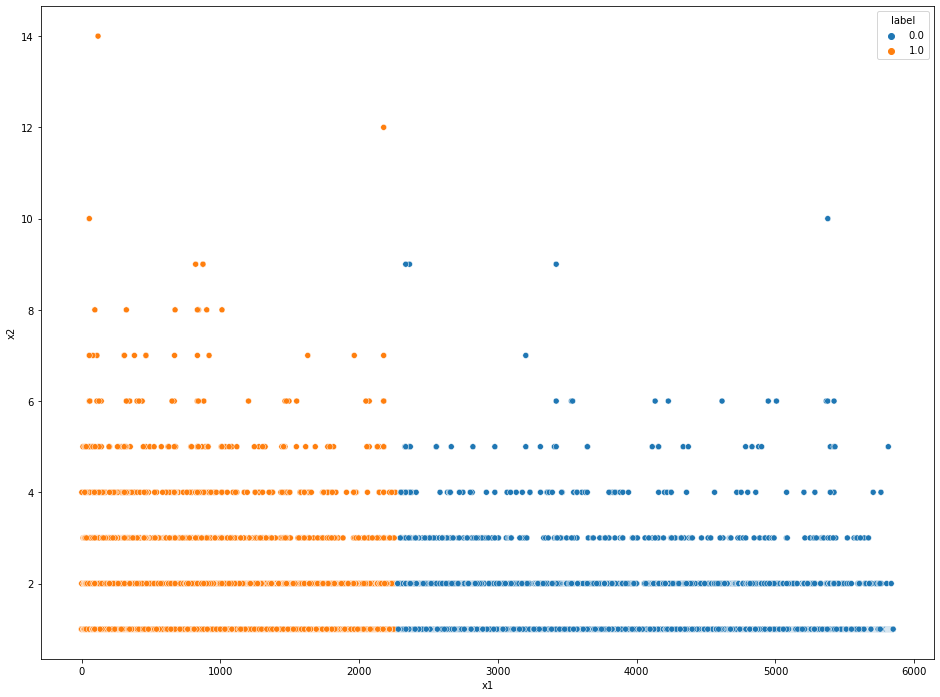

In [19]:
plt.figure(figsize=(16,12))
sns.scatterplot(x=df_corpus['x1'],
                y=df_corpus['x2'],
                data= df_corpus,
                legend='full',
                hue='label'
               )

In [20]:
import tomotopy as tp
term_weight = tp.TermWeight.ONE
hdp = tp.HDPModel(tw=term_weight,min_cf=5,rm_top=7,gamma=1,alpha=0.1,initial_k=10,seed=99999)

In [21]:
for vec in word_list_lemmatized:
    hdp.add_doc(vec)

hdp.burn_in =100
hdp.train(0)

print('Num docs:', len(hdp.docs),',Vocab size:',hdp.num_vocabs,
    ',Num words:',hdp.num_words)

print("Removed top words:",hdp.removed_top_words)

# Train Model

for i in range(0,1000,100):
    hdp.train(100)
    print('Iteration:{}\tLog-likelihood:{}\tNum of topics: {}'.format(i,hdp.ll_per_word,hdp.live_k))

Num docs: 299 ,Vocab size: 1472 ,Num words: 20468
Removed top words: ['Australia', 'people', 'day', 'year', 'force', 'israeli', 'attack']
Iteration:0	Log-likelihood:-7.128029091215609	Num of topics: 125
Iteration:100	Log-likelihood:-7.0495954501994635	Num of topics: 137
Iteration:200	Log-likelihood:-7.032020390348228	Num of topics: 141
Iteration:300	Log-likelihood:-7.06155372485999	Num of topics: 128
Iteration:400	Log-likelihood:-7.041140225953089	Num of topics: 130
Iteration:500	Log-likelihood:-6.996679786629851	Num of topics: 133
Iteration:600	Log-likelihood:-6.987063587934961	Num of topics: 133
Iteration:700	Log-likelihood:-7.00850750406622	Num of topics: 129
Iteration:800	Log-likelihood:-6.965619716253834	Num of topics: 138
Iteration:900	Log-likelihood:-6.9830043791140435	Num of topics: 129


In [22]:
def get_hdp_topics(hdp, top_n=10):
    '''Wrapper function to extract topics from trained tomotopy HDP model 
    
    ** Inputs **
    hdp:obj -> HDPModel trained model
    top_n: int -> top n words in topic based on frequencies
    
    ** Returns **
    topics: dict -> per topic, an arrays with top words and associated frequencies 
    '''
    
    # Get most important topics by # of times they were assigned (i.e. counts)
    sorted_topics = [k for k, v in sorted(enumerate(hdp.get_count_by_topics()), key=lambda x:x[1], reverse=True)]

    topics=dict()
    
    # For topics found, extract only those that are still assigned
    for k in sorted_topics:
        if not hdp.is_live_topic(k): continue # remove un-assigned topics at the end (i.e. not alive)
        topic_wp =[]
        for word, prob in hdp.get_topic_words(k, top_n=top_n):
            topic_wp.append((word, prob))

        topics[k] = topic_wp # store topic word/frequency array
        
    return topics

In [23]:
def eval_coherence(topics_dict, word_list, coherence_type='c_v'):
    '''Wrapper function that uses gensim Coherence Model to compute topic coherence scores
    
    ** Inputs **
    topic_dict: dict -> topic dictionary from train_HDPmodel function
    word_list: list -> lemmatized word list of lists
    coherence_typ: str -> type of coherence value to comput (see gensim for opts)
    
    ** Returns **
    score: float -> coherence value
    '''
    
    # Build gensim objects
    vocab = corpora.Dictionary(word_list)
    corpus = [vocab.doc2bow(words) for words in word_list]
    
    # Build topic list from dictionary
    topic_list=[]
    for k, tups in topics_dict.items():
        topic_tokens=[]
        for w, p in tups:
            topic_tokens.append(w)
            
        topic_list.append(topic_tokens)
            

    # Build Coherence model
    print("Evaluating topic coherence...")
    cm = CoherenceModel(topics=topic_list, corpus=corpus, dictionary=vocab, texts=word_list, 
                    coherence=coherence_type)
    
    score = cm.get_coherence()
    print ("Done\n")
    return score

# topic weights

In [24]:
topics = get_hdp_topics(hdp)
topics_keylist = list(topics.keys())
topics[0][0][0]

'Adventure_World'

In [25]:
topics

{4: [('palestinian', 0.025953318923711777),
  ('Arafat', 0.023563195019960403),
  ('Israel', 0.015368488617241383),
  ('kill', 0.015027042478322983),
  ('official', 0.015027042478322983),
  ('Hamas', 0.014685596339404583),
  ('militant', 0.012978365644812584),
  ('arrest', 0.010929688811302185),
  ('Sharon', 0.01024679746478796),
  ('West_Bank', 0.00990535132586956)],
 6: [('Afghanistan', 0.019466860219836235),
  ('United_States', 0.012729627080261707),
  ('believe', 0.011606755666434765),
  ('fighter', 0.011232464574277401),
  ('Al_Qaeda', 0.010858174413442612),
  ('afghan', 0.010109592229127884),
  ('Laden', 0.009735302068293095),
  ('Osama_bin', 0.008986719883978367),
  ('tell', 0.008612429723143578),
  ('leader', 0.008238138630986214)],
 9: [('fire', 0.02393856644630432),
  ('area', 0.019715355709195137),
  ('Sydney', 0.019011488184332848),
  ('metre', 0.01619601435959339),
  ('firefighter', 0.01619601435959339),
  ('wind', 0.014084408059716225),
  ('Wales', 0.011268934234976768),
